In [1]:
#LSTM/Experiment_1_LSTM.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
from keras.utils.np_utils import to_categorical
import glob
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import numpy
import keras.models
import tensorflow
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import matplotlib.pyplot
from matplotlib import pyplot
from tensorflow.keras.layers import Dense, Dropout, LSTM

from matplotlib import pyplot

import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from datetime import datetime
import warnings
import itertools
import numpy as np
from statsmodels.tsa.stattools import adfuller

from math import sqrt
warnings.filterwarnings("ignore")
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from datetime import datetime
import warnings
import itertools
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from prophet import Prophet
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import plotly.offline

##**Read the Data**

In [ ]:
fin_data = pd.read_csv('/content/gdrive/MyDrive/Sent/final_data_May20_Sept22.csv') #without outliers 

In [ ]:
fin_data_exp = fin_data.groupby(['Year','Month','Day','Hour'])['nitrogendioxide_tropospheric_column','nitrogendioxide_tropospheric_column_precision','nitrogendioxide_tropospheric_column_precision_kernel', 'air_mass_factor_troposphere', 'air_mass_factor_total',	'pm10'].mean()
#fin_data_exp = fin_data.groupby(['Year','Month','Day','Hour'])['nitrogendioxide_tropospheric_column','nitrogendioxide_tropospheric_column_precision','nitrogendioxide_tropospheric_column_precision_kernel',	'pm10'].mean()

In [ ]:
fin_data_exp=fin_data_exp.reset_index()
# fin_data_exp=fin_data_exp.drop(columns=['level_0', 'index', 'Year', 'Month', 'Day', 'Hour'])
# fin_data_exp.head()

In [ ]:
fin_data_exp=fin_data_exp.drop(columns=['Year', 'Month', 'Day', 'Hour'])
fin_data_exp.head()

,nitrogendioxide_tropospheric_column,nitrogendioxide_tropospheric_column_precision,nitrogendioxide_tropospheric_column_precision_kernel,air_mass_factor_troposphere,air_mass_factor_total,pm10
0,0.000008,0.000013,0.000013,1.012013,1.824901,6.261500
1,0.000017,0.000011,0.000010,1.515475,2.277400,6.261500
2,0.000046,0.000021,0.000019,1.010297,1.868061,7.395500
3,0.000033,0.000015,0.000013,1.172698,1.842592,7.395500
4,0.000039,0.000020,0.000019,0.967595,2.293194,10.091111


##**Feature Engineering for LSTM**

In [ ]:
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:

			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = fin_data_exp.values
# integer encode direction
encoder = LabelEncoder()
#values[:,8] = encoder.fit_transform(values[:,8])
values
# ensure all data is float
values = values.astype('float32')
# normalize features

#values = lstm_data(values, 4)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1) #tow days win
#reframed.drop(reframed.columns[[9,10,11]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True) #window two
reframed.head()


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
1,0.155634,0.013603,0.015260,0.427553,0.546352,0.129479,0.164217,0.005729,0.005855,0.654652,0.739136,0.129479
2,0.164217,0.005729,0.005855,0.654652,0.739136,0.129479,0.191809,0.036969,0.033096,0.426778,0.564740,0.201648
3,0.191809,0.036969,0.033096,0.426778,0.564740,0.201648,0.179365,0.018086,0.015359,0.500033,0.553890,0.201648
4,0.179365,0.018086,0.015359,0.500033,0.553890,0.201648,0.185115,0.034446,0.032485,0.407516,0.745865,0.373201
5,0.185115,0.034446,0.032485,0.407516,0.745865,0.373201,0.188677,0.039848,0.037652,0.307705,0.455237,0.373201


In [ ]:
reframed.shape

(985, 18)

In [ ]:
reframed1 = reframed.iloc[:,:-1]
reframed1 = lstm_data(reframed1, 3)

In [ ]:
reframed.shape

(985, 18)

In [ ]:
values1.shape

(985, 18)

#***Model 1 LSTM (window one)***






In [ ]:

values = reframed.values
#values1 = reframed.values
x, x_test, y, y_test = train_test_split(values[:, :-1],values[:,-1],test_size=0.1,train_size=0.9, random_state=None, shuffle=False)
x_train, x_val, train_y, val_y = train_test_split(x,y,test_size = 0.2,train_size =0.8, random_state=None, shuffle=False)
# reshape input to be 3D [samples, timesteps, features]
# train_X = x_train.copy()
# val_X = x_val.copy()
# test_X = x_test.copy()

# val_y=val_y[1]
# y_test= y_test[1]

train_X = x_train.reshape((x_train.shape[0], 1, x_train.shape[1])) 
val_X = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
test_X = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, y_test.shape)

(709, 1, 6) (709,) (178, 1, 6) (178,) (99, 1, 6) (99,)


Epoch 1/50
12/12 - 3s - loss: 0.4691 - val_loss: 0.3270 - 3s/epoch - 219ms/step
Epoch 2/50
12/12 - 0s - loss: 0.2375 - val_loss: 0.1824 - 246ms/epoch - 20ms/step
Epoch 3/50
12/12 - 0s - loss: 0.1870 - val_loss: 0.1870 - 243ms/epoch - 20ms/step
Epoch 4/50
12/12 - 0s - loss: 0.1936 - val_loss: 0.1725 - 259ms/epoch - 22ms/step
Epoch 5/50
12/12 - 0s - loss: 0.1771 - val_loss: 0.1688 - 239ms/epoch - 20ms/step
Epoch 6/50
12/12 - 0s - loss: 0.1712 - val_loss: 0.1649 - 246ms/epoch - 20ms/step
Epoch 7/50
12/12 - 0s - loss: 0.1695 - val_loss: 0.1612 - 256ms/epoch - 21ms/step
Epoch 8/50
12/12 - 0s - loss: 0.1641 - val_loss: 0.1562 - 255ms/epoch - 21ms/step
Epoch 9/50
12/12 - 0s - loss: 0.1581 - val_loss: 0.1527 - 245ms/epoch - 20ms/step
Epoch 10/50
12/12 - 0s - loss: 0.1550 - val_loss: 0.1484 - 243ms/epoch - 20ms/step
Epoch 11/50
12/12 - 0s - loss: 0.1515 - val_loss: 0.1441 - 241ms/epoch - 20ms/step
Epoch 12/50
12/12 - 0s - loss: 0.1471 - val_loss: 0.1394 - 282ms/epoch - 23ms/step
Epoch 13/50
12/

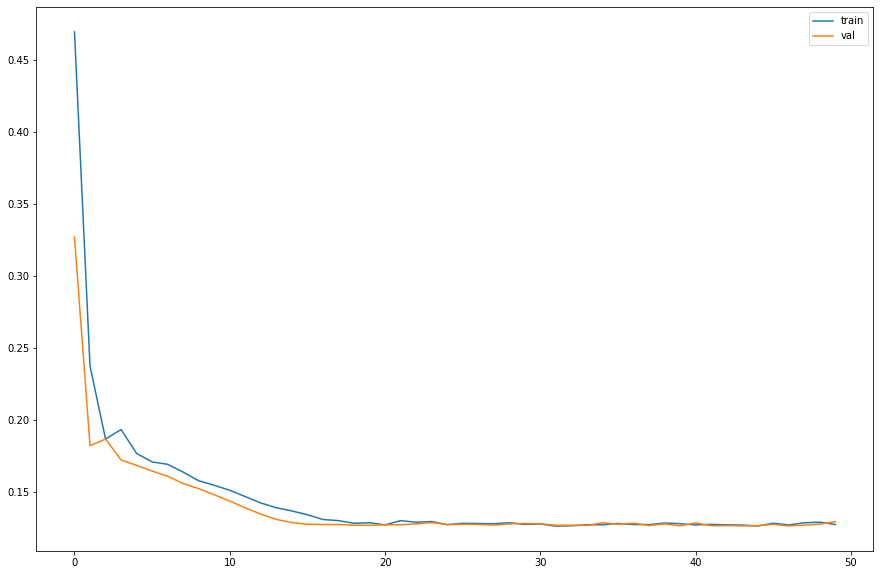

6/6 [==============================] - 0s 5ms/step


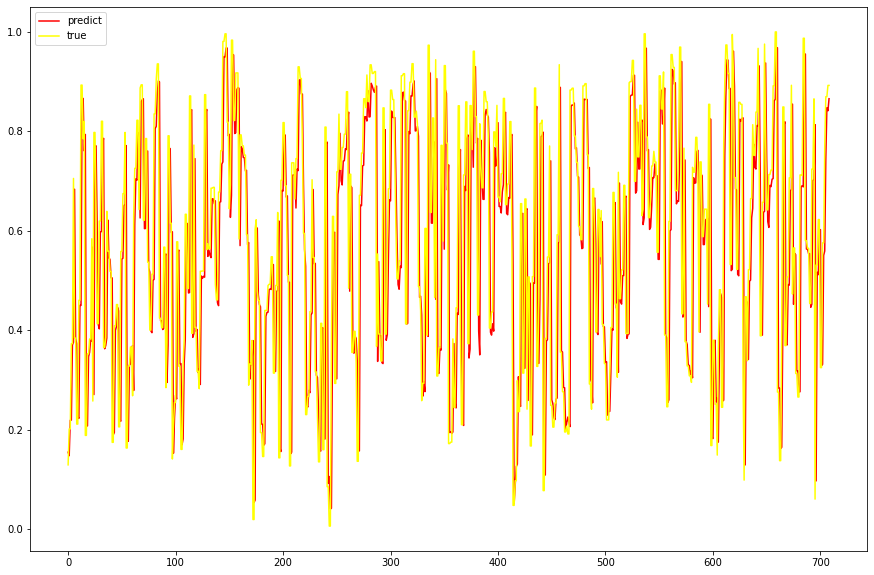

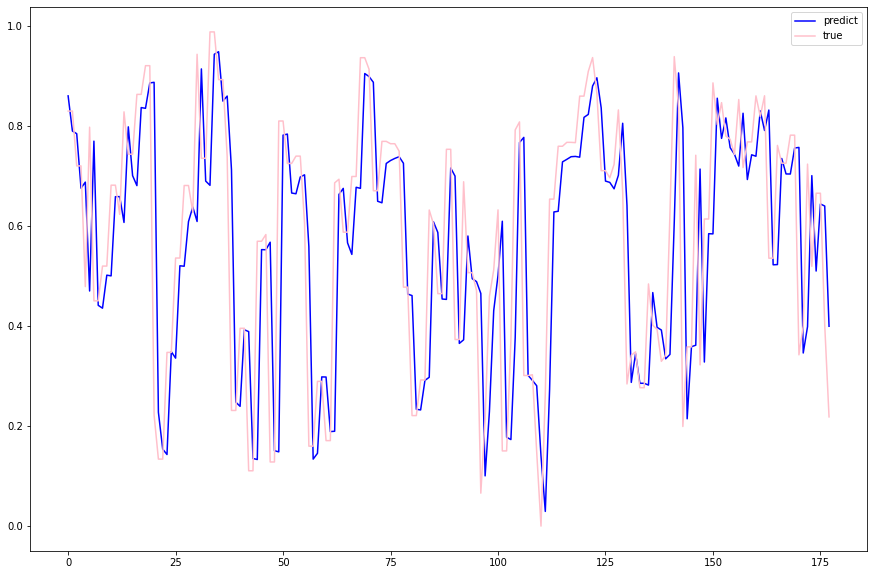

In [ ]:
# design network

#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

model = Sequential()
model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(1000, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(2000, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam') #mean absolute error 



history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
plt.figure(figsize=(15, 10))

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

y_hat = model.predict(train_X)
y_hat_val = model.predict(val_X)

plt.figure(figsize=(15, 10))
pyplot.plot(y_hat, label='predict', color = 'red')
pyplot.plot(train_y, label='true', color = 'yellow')
# pyplot.plot(y_hat_val, label='predict', color = 'blue')
# pyplot.plot(val_y, label='true', color = 'pink')
pyplot.legend()

pyplot.show()


plt.figure(figsize=(15, 10))
pyplot.plot(y_hat_val, label='predict', color = 'blue')
pyplot.plot(val_y, label='true', color = 'pink')
pyplot.legend()

pyplot.show()
#plot the training/validation set , plot all the sets together in one image 


4/4 [==============================] - 0s 5ms/step


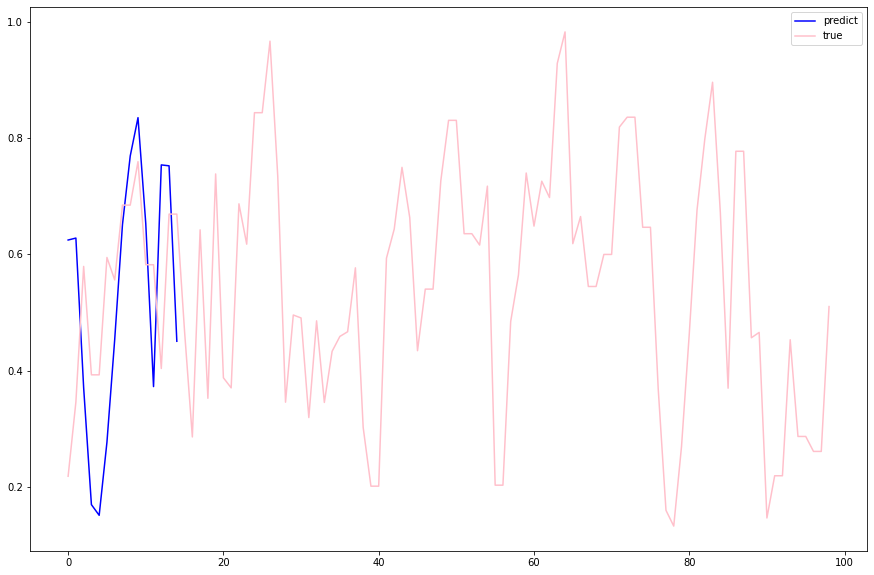

MSE comparison ----
LSTM:	0.0320
R2_score ----
LSTMf:	0.1574


In [ ]:
y_hat_test = model.predict(test_X)

plt.figure(figsize=(15, 10))

pyplot.plot(y_hat_test[75:90], label='predict', color = 'blue')
pyplot.plot(y_test, label='true', color = 'pink')
pyplot.legend()

pyplot.show()



print('MSE comparison ----')

print(f"LSTM:\t{mean_squared_error(y_hat_test, y_test):.4f}")


print('R2_score ----')

print(f"LSTMf:\t{r2_score(y_hat_test, y_test):.4f}")
